In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/gan_experiments'
os.chdir(path_basic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid');

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import pandas as pd
import numpy as np
import scipy.stats as st
import glob

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [0]:
def sit_to_dict(summary_iterators, tags, default_tag='G/GAN_A2B'):
  tag_values = defaultdict(list)

  for i in range(len(summary_iterators)):
    if i == len(summary_iterators) - 1:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag]
        tag_values[tag].extend(values_now)

      print(f"S-{i}: first:last step - {steps_now[0]}:{steps_now[-1]} - {len(steps_now)}")
    else:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      steps_next = [e.step for e in summary_iterators[i+1].Scalars(default_tag)]
      start = min(steps_now)
      stop = min(steps_next)
      if start - stop == 0:
        continue

      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag if e.step <= stop]
        tag_values[tag].extend(values_now)
      print(f"S-{i}: first:last step - {start}:{stop} - {len(steps_now)}")

    

  return tag_values

In [0]:
def get_sit(path):
  summary_iterators = [EventAccumulator(path_).Reload() 
                    for path_ in sorted(glob.glob(os.path.join(path, "*.*")))
                    ]
  summary_iterators = [s for s in summary_iterators if len(s.Tags()['scalars']) > 0]
  return summary_iterators


def get_csv(dict_object, tag):

  values = dict_object[tag]
  steps = [s[0] for s in values]
  values = [v[1] for v in values]

  df = pd.DataFrame(columns=['index', 'values'])
  df['index'] = steps
  df['values'] = values
  df = df.set_index('index')
  return df

In [0]:
def get_results_dict(path, stop_it):
  summary_iterator = get_sit(path)
  tags = summary_iterator[0].Tags()['scalars']
  tag_values = sit_to_dict(summary_iterator, tags)

  results = {}
  for tag in tags:
    df_values = get_csv(tag_values, tag)
    df_values = df_values[df_values.index < stop_it].copy()
    results[tag] = df_values.copy()

  return results

### Cross base method


In [0]:
# !kill 334

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_cam_v0.0.1/1/'
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_dilated_v0.0.1/1/'

In [0]:
os.listdir('mask_shadow_gan/output/summary/cam_cross/summary_cam_base_v0.0.1')

['summary_cam_notrans_v0.0.1',
 'summary_cam_trans_nomask_v0.0.1',
 'summary_ins_reb_v0.0.1',
 'summary_ins_cat_v0.0.1',
 'summary_cam_base_v0.0.1',
 'summary_cam_v0.0.1']

In [0]:
PATH_010 = 'mask_shadow_gan/output/summary/cam_cross/summary_cam_base_v0.0.1/1/'

In [0]:
STOP_IT = 1e6  # take all
print("V.0.1.0")
results_010 = get_results_dict(PATH_010, STOP_IT)

V.0.1.0
S-0: first:last step - 10:1240 - 123
S-1: first:last step - 1240:8620 - 1073
S-2: first:last step - 8620:46960 - 3835


In [0]:
tag_score = 'Score/val_rmse_whole'
df_spec_score_global_010 = results_010[tag_score]

tag_score = 'Score/val_rmse_region'
df_spec_score_local_010 = results_010[tag_score]

tag_iou = 'Score/val_iou'
df_spec_iou_010 = results_010[tag_iou]

In [0]:
def scale(df):
  return df / df.mean()

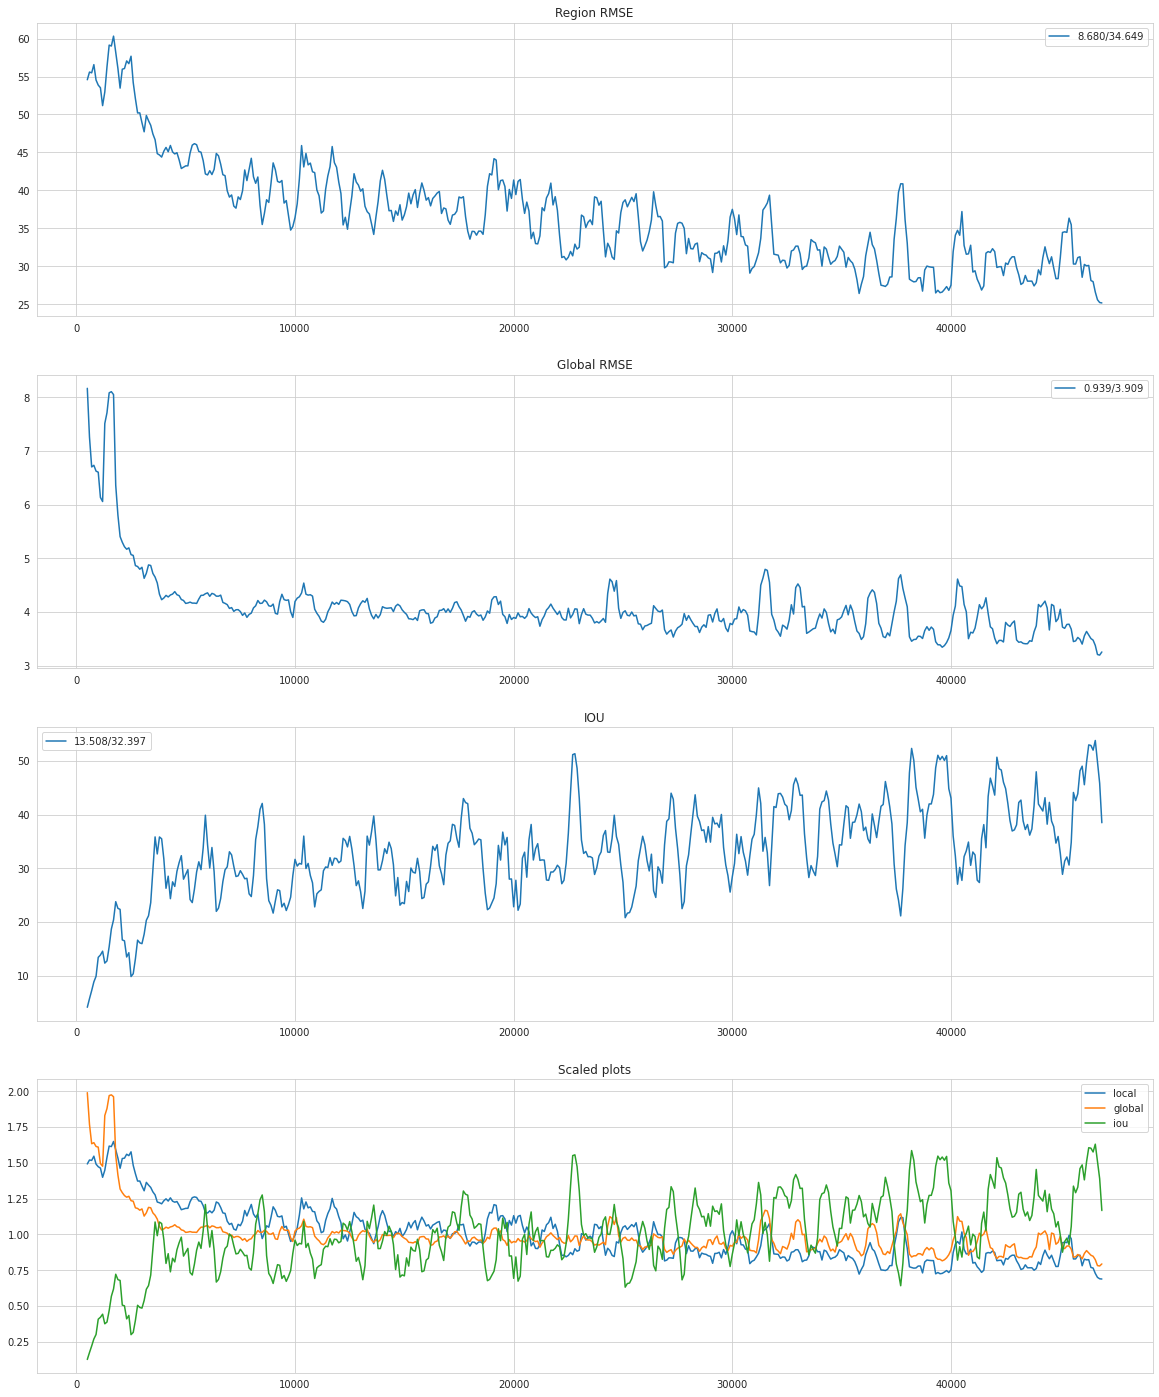

In [0]:
rm=5
plt.subplots(figsize=(20,10))
plt.subplot(4,1,1)
plt.title("Region RMSE")
plt.plot(df_spec_score_local_010.rolling(rm).mean(), 
          label=f'{df_spec_score_local_010.std()[0]:.3f}/{df_spec_score_local_010.median()[0]:.3f}');
plt.legend();


plt.subplot(4,1,2)
plt.title("Global RMSE")
plt.plot(df_spec_score_global_010.rolling(rm).mean(), 
          label=f'{df_spec_score_global_010.std()[0]:.3f}/{df_spec_score_global_010.median()[0]:.3f}');
plt.legend();

plt.subplot(4,1,3)
plt.title("IOU")
plt.plot(df_spec_iou_010.rolling(rm).mean(), 
          label=f'{df_spec_iou_010.std()[0]:.3f}/{df_spec_iou_010.median()[0]:.3f}');
plt.legend();

plt.subplot(4, 1, 4)
data = (('local', scale(df_spec_score_local_010)),
        ('global',  scale(df_spec_score_global_010)),
        ('iou',  scale(df_spec_iou_010)))

for i,(label, score) in enumerate(data):
  plt.title("Scaled plots")
  plt.plot(score.rolling(rm).mean(), label=f"{label}")
  plt.legend();

plt.subplots_adjust(top=2);

In [0]:
tag_gab = 'G/GAN_A2B'
df_spec_gab_010 = results_010[tag_gab]

tag_db_real = 'D/D_B_real'
df_spec_db_real_010 = results_010[tag_db_real]


tag_db_fake = 'D/D_B_fake'
df_spec_db_fake_010 = results_010[tag_db_fake]

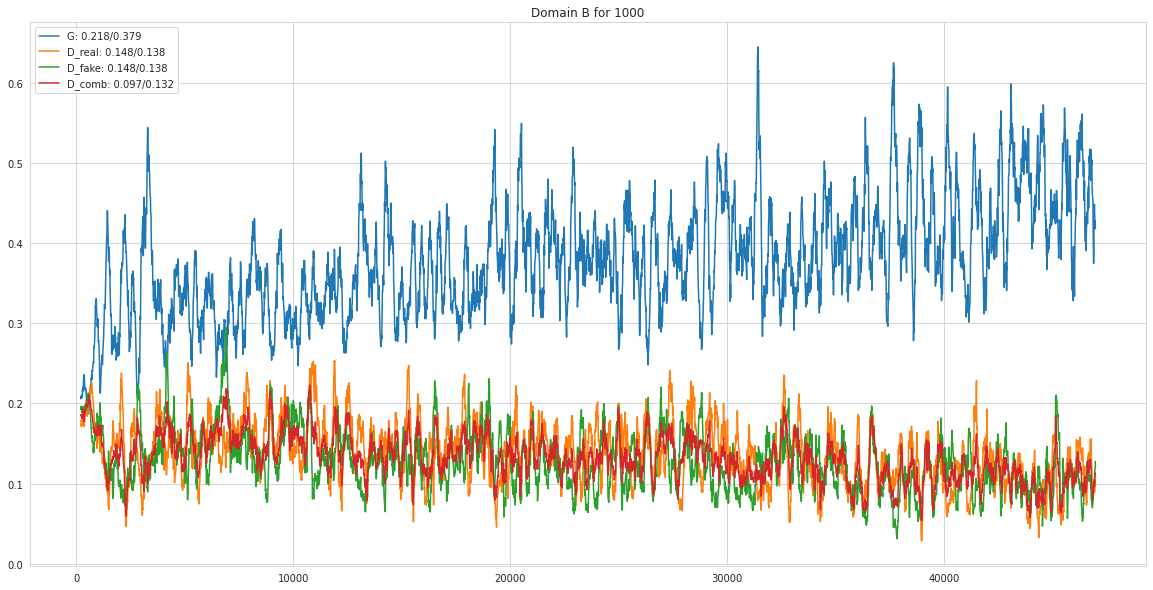

In [0]:
rm = 20
plt.subplots(figsize=(20,10))
plt.title("Domain B for 1000")
plt.plot(df_spec_gab_010.rolling(rm).mean(), 
         label=f'G: {df_spec_gab_010.std()[0]:.3f}/{df_spec_gab_010.mean()[0]:.3f}');

plt.plot(df_spec_db_real_010.rolling(rm).mean(), 
         label=f'D_real: {df_spec_db_real_010.std()[0]:.3f}/{df_spec_db_real_010.mean()[0]:.3f}');
plt.plot(df_spec_db_fake_010.rolling(rm).mean(), 
         label=f'D_fake: {df_spec_db_real_010.std()[0]:.3f}/{df_spec_db_real_010.mean()[0]:.3f}');
# combined
df_spec_db_fake_comb_010 = (df_spec_db_real_010 + df_spec_db_fake_010) / 2
plt.plot(df_spec_db_fake_comb_010.rolling(rm).mean(), 
         label=f'D_comb: {df_spec_db_fake_comb_010.std()[0]:.3f}/{df_spec_db_fake_comb_010.mean()[0]:.3f}');
plt.legend();

In [0]:
tag_gba = 'G/GAN_B2A'
df_spec_gba_010 = results_010[tag_gba]

tag_da_real = 'D/D_A_real'
df_spec_da_real_010 = results_010[tag_da_real]

tag_da_fake = 'D/D_A_fake'
df_spec_da_fake_010 = results_010[tag_da_fake]

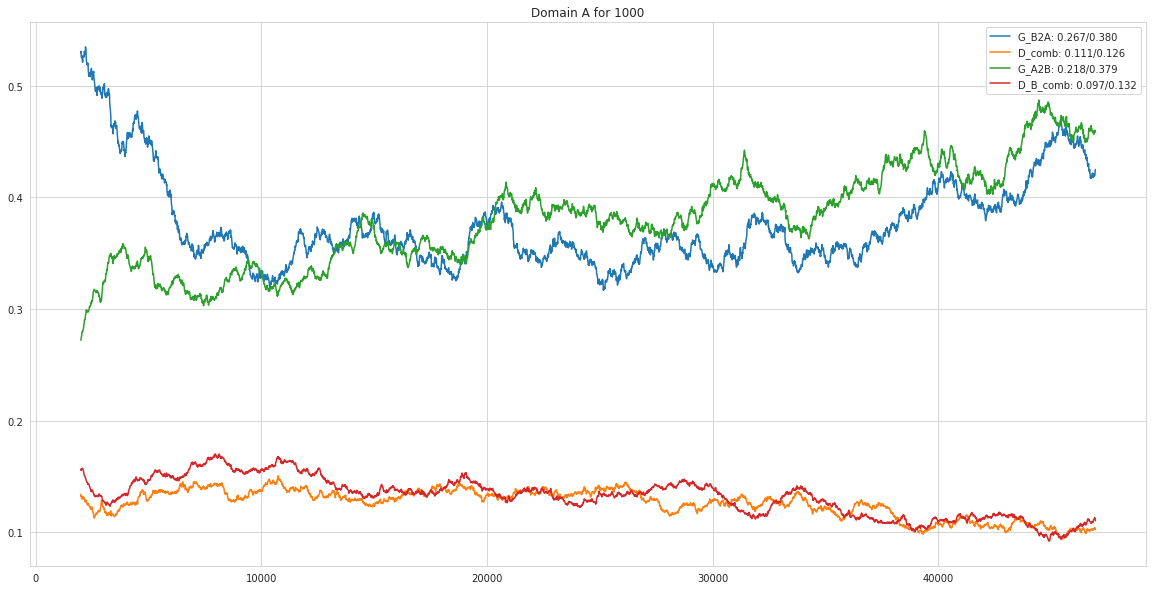

In [0]:
rm = 200
plt.subplots(figsize=(20,10))
plt.title("Domain A for 1000")
plt.plot(df_spec_gba_010.rolling(rm).mean(), 
         label=f'G_B2A: {df_spec_gba_010.std()[0]:.3f}/{df_spec_gba_010.mean()[0]:.3f}');

# combined
df_spec_da_fake_comb_010 = (df_spec_da_real_010 + df_spec_da_fake_010) / 2
plt.plot(df_spec_da_fake_comb_010.rolling(rm).mean(), 
         label=f'D_comb: {df_spec_da_fake_comb_010.std()[0]:.3f}/{df_spec_da_fake_comb_010.mean()[0]:.3f}');


plt.plot(df_spec_gab_010.rolling(rm).mean(), 
         label=f'G_A2B: {df_spec_gab_010.std()[0]:.3f}/{df_spec_gab_010.mean()[0]:.3f}');
# combined
df_spec_db_fake_comb_010 = (df_spec_db_real_010 + df_spec_db_fake_010) / 2
plt.plot(df_spec_db_fake_comb_010.rolling(rm).mean(), 
         label=f'D_B_comb: {df_spec_db_fake_comb_010.std()[0]:.3f}/{df_spec_db_fake_comb_010.mean()[0]:.3f}');

plt.legend();

### Comparison of ugatit-500 and cross-500

In [0]:
PATH_010 = 'mask_shadow_gan/output/summary/cam_cross/summary_cam_base_v0.0.1/1/'
PATH_011 = 'mask_shadow_gan/output/summary/ugatit/summary_coef_v0.0.1/500/'

In [8]:
STOP_IT = 1e6  # take all
print("V.0.1.0")
results_010 = get_results_dict(PATH_010, STOP_IT)

print("\nV.0.1.1")
results_011 = get_results_dict(PATH_011, STOP_IT)


V.0.1.0
S-0: first:last step - 10:1240 - 123
S-1: first:last step - 1240:8620 - 1073
S-2: first:last step - 8620:46750 - 3835
S-3: first:last step - 46750:67000 - 2026

V.0.1.1
S-0: first:last step - 10:3510 - 350
S-1: first:last step - 3510:6960 - 345
S-2: first:last step - 6960:42630 - 3838
S-3: first:last step - 42630:56160 - 1960
S-4: first:last step - 56160:91980 - 3583


In [0]:
assert all([s in results_011.keys() for s in ['Score/val_rmse_region', 'Score/val_iou', 'Score/val_rmse_whole'] ])
assert all([s in results_010.keys() for s in ['Score/val_rmse_region', 'Score/val_iou', 'Score/val_rmse_whole'] ])

In [0]:
tag_score = 'Score/val_rmse_region'
df_spec_score_region_010 = results_010[tag_score]
df_spec_score_region_011 = results_011[tag_score]


tag_score = 'Score/val_rmse_whole'
df_spec_score_whole_010 = results_010[tag_score]
df_spec_score_whole_011 = results_011[tag_score]


tag_iou = 'Score/val_iou'
df_spec_iou_010 = results_010[tag_iou]
df_spec_iou_011 = results_011[tag_iou]


In [0]:
# # as soon as rmse region and whole were written with same tag
# # take odd numbers for region
# df_spec_score_region_010 = df_spec_score_010.iloc[np.arange(1,df_spec_score_010.shape[0], 2)].copy()
# df_spec_score_whole_010 = df_spec_score_010.iloc[np.arange(0,df_spec_score_010.shape[0], 2)].copy()

# df_spec_score_region_011 = df_spec_score_011.iloc[np.arange(1,df_spec_score_011.shape[0], 2)].copy()
# df_spec_score_whole_011 = df_spec_score_011.iloc[np.arange(0,df_spec_score_011.shape[0], 2)].copy()

# df_spec_score_region_013 = df_spec_score_013.iloc[np.arange(1,df_spec_score_013.shape[0], 2)].copy()
# df_spec_score_whole_013 = df_spec_score_013.iloc[np.arange(0,df_spec_score_013.shape[0], 2)].copy()

In [11]:
df_spec_score_region_010.shape[0], df_spec_score_region_011.shape[0]

(670, 919)

In [0]:
# min_len = int(1e6)
min_len = min(len(df_spec_score_region_010), len(df_spec_score_region_011))

In [0]:
df_spec_score_whole_010

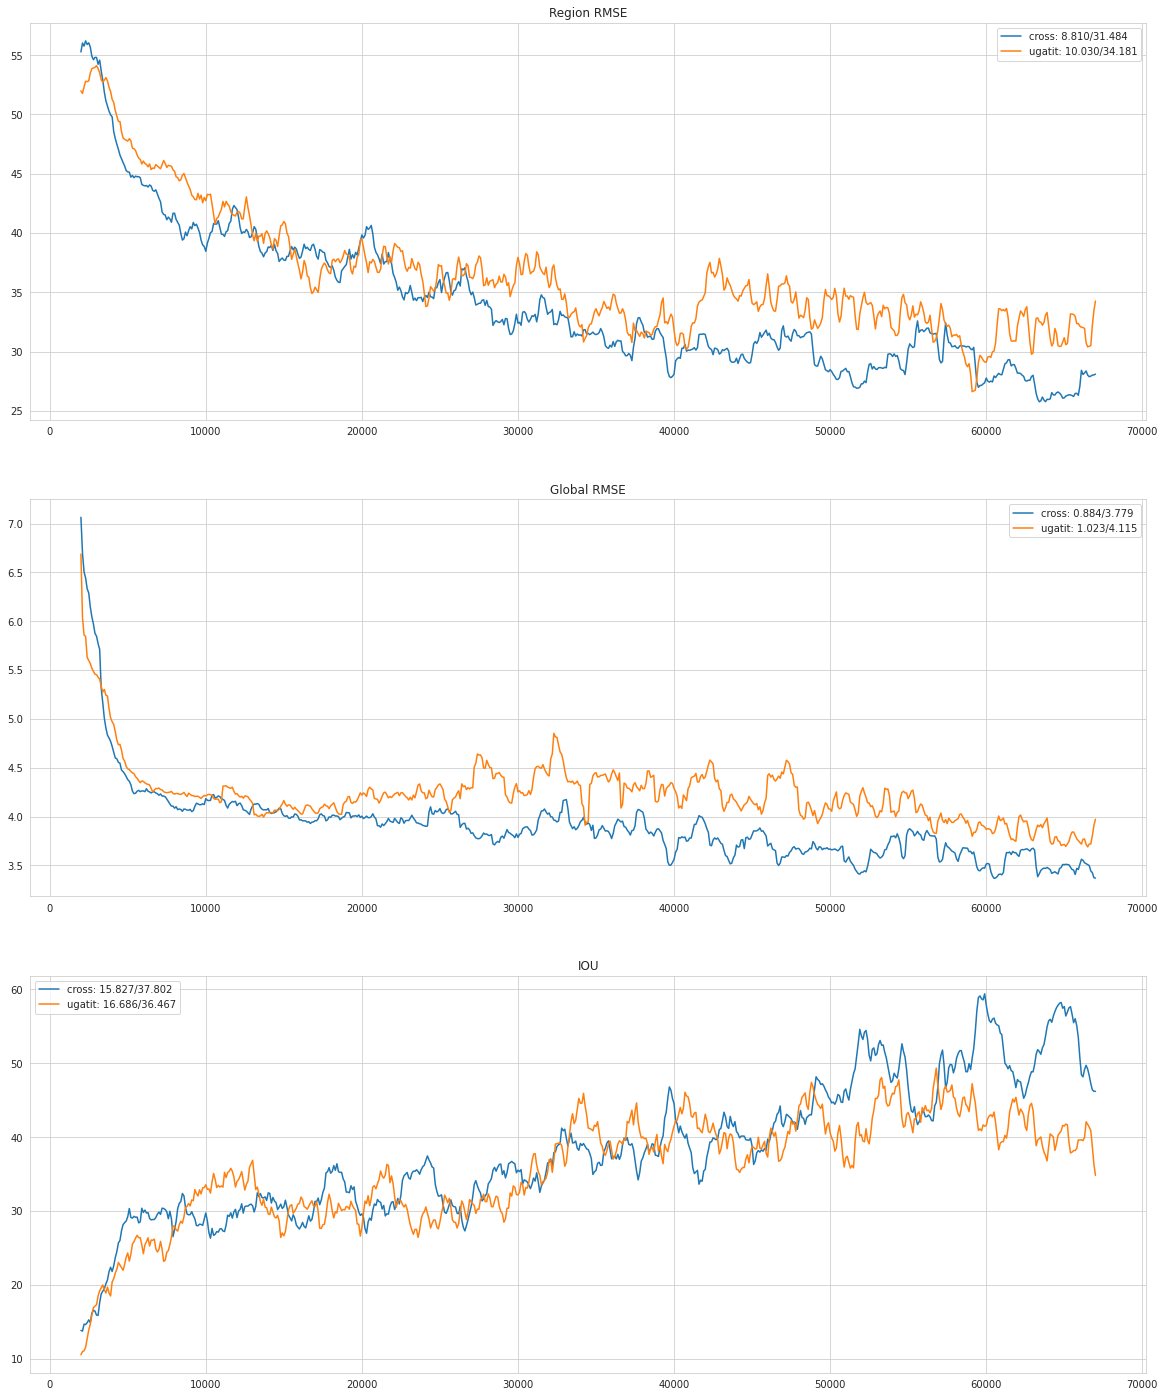

In [13]:
rm=20
plt.subplots(figsize=(20,10))
plt.subplot(3,1,1)
plt.title("Region RMSE")
data = [('cross', df_spec_score_region_010.iloc[:min_len]), 
        ('ugatit', df_spec_score_region_011.iloc[:min_len])]
for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();


plt.subplot(3,1,2)
plt.title("Global RMSE")
data = [('cross', df_spec_score_whole_010.iloc[:min_len]), 
        ('ugatit', df_spec_score_whole_011.iloc[:min_len])]
for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();

plt.subplot(3,1,3)
plt.title("IOU")
data = [('cross', df_spec_iou_010.iloc[:min_len]), 
        ('ugatit', df_spec_iou_011.iloc[:min_len])]

for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();


plt.subplots_adjust(top=2);

- Global rmse has rather slow convergence combined with more volatile loss compared to dilated counterpart
  - It may say about bad background reconstruction, this should be further examined with identity loss and visual comparison

- Local RMSE seems to have a strong negative trend for all coefficients.
- Same situation goes for IOU. So we generate better masks with time.

In average, 100 coefficient shows better behaviour on all graphs.

### Look at correlation of region rmse with iou

In [0]:
def scale(df):
  # return (df - df.mean()) / df.std()
  return df / df.mean()

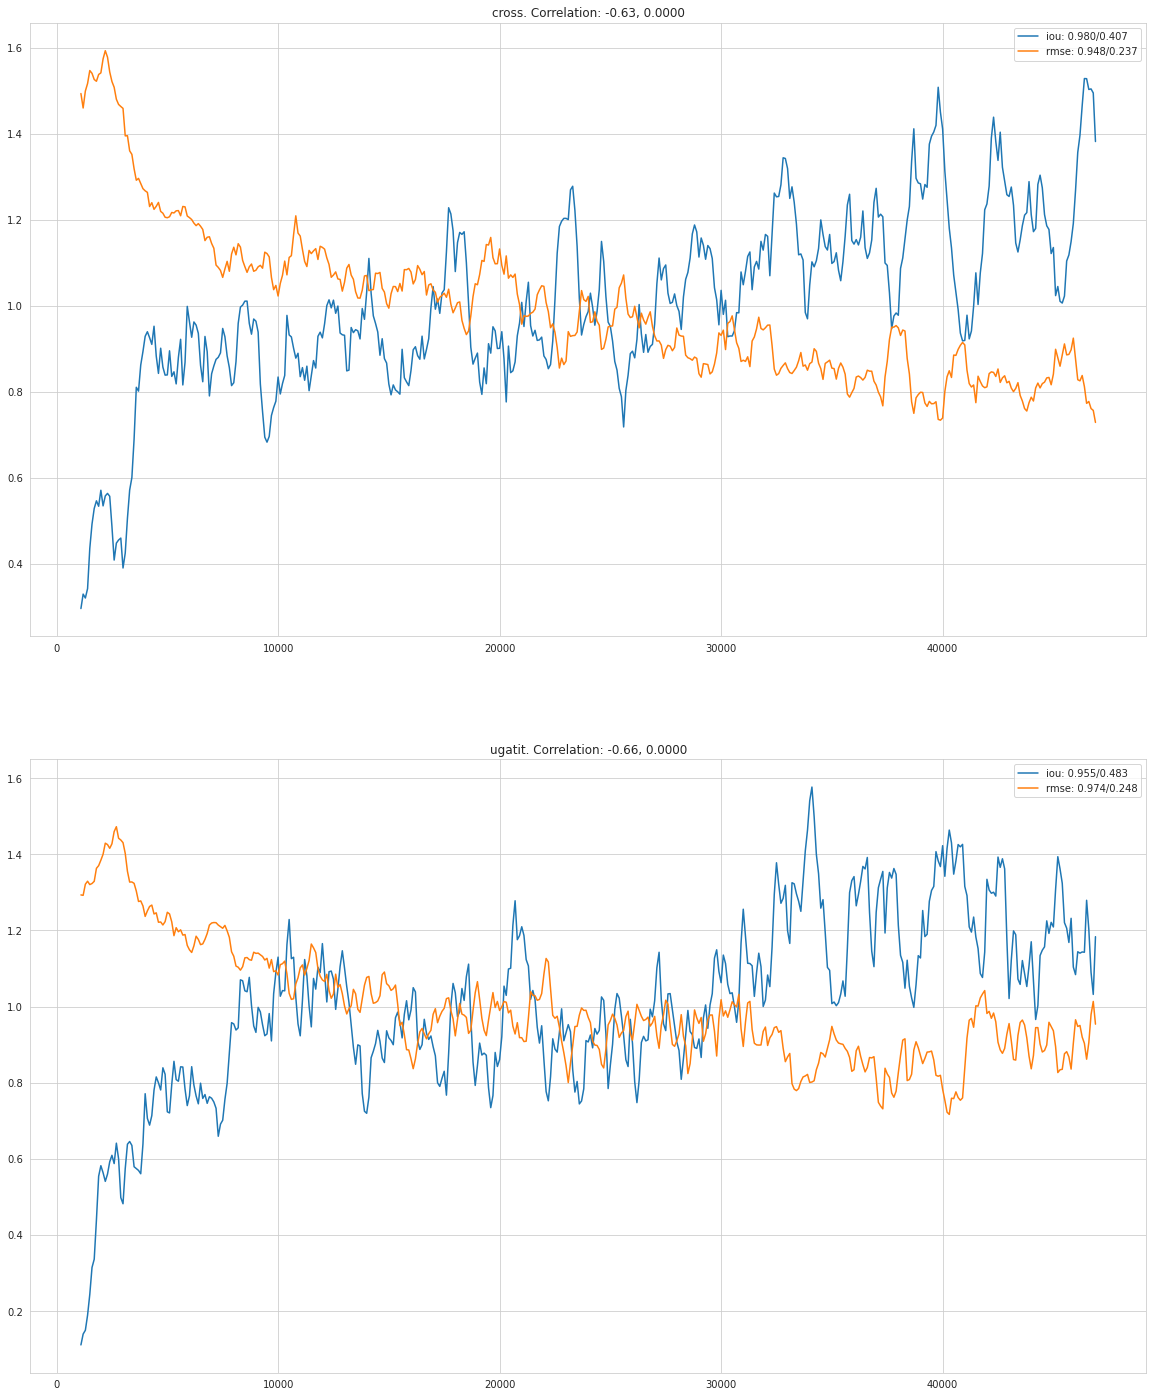

In [0]:
start_index = 1
plt.subplots(figsize=(20,10))
data = ((10,'cross', scale(df_spec_iou_010.iloc[start_index:min_len]), scale(df_spec_score_region_010.iloc[start_index:min_len])),
        (10, 'ugatit',  scale(df_spec_iou_011.iloc[start_index:min_len]), scale(df_spec_score_region_011.iloc[start_index:min_len])))

for i,(rm, label, iou, rmse) in enumerate(data):
  plt.subplot(len(data), 1, i+1)
  corr,pv = st.pearsonr(iou.values.squeeze(), rmse.values.squeeze())
  plt.title(f"{label}. Correlation: {corr:.2f}, {pv:.4f}")
  plt.plot(iou.rolling(rm).mean(), label=f"iou: {iou.median()[0]:.3f}/{iou.std()[0]:.3f}")
  plt.plot(rmse.rolling(rm).mean(), label=f"rmse: {rmse.median()[0]:.3f}/{rmse.std()[0]:.3f}")
  plt.legend();

plt.subplots_adjust(top=2);

- We have a significant negative correlation for all hypothesis.
- Models with higher weights(500,1000) have smaller gap with training progress
- 100 seems to be more consistent and less volatile, given strong negative correlation

### Correlation of Global RMSE with IOU

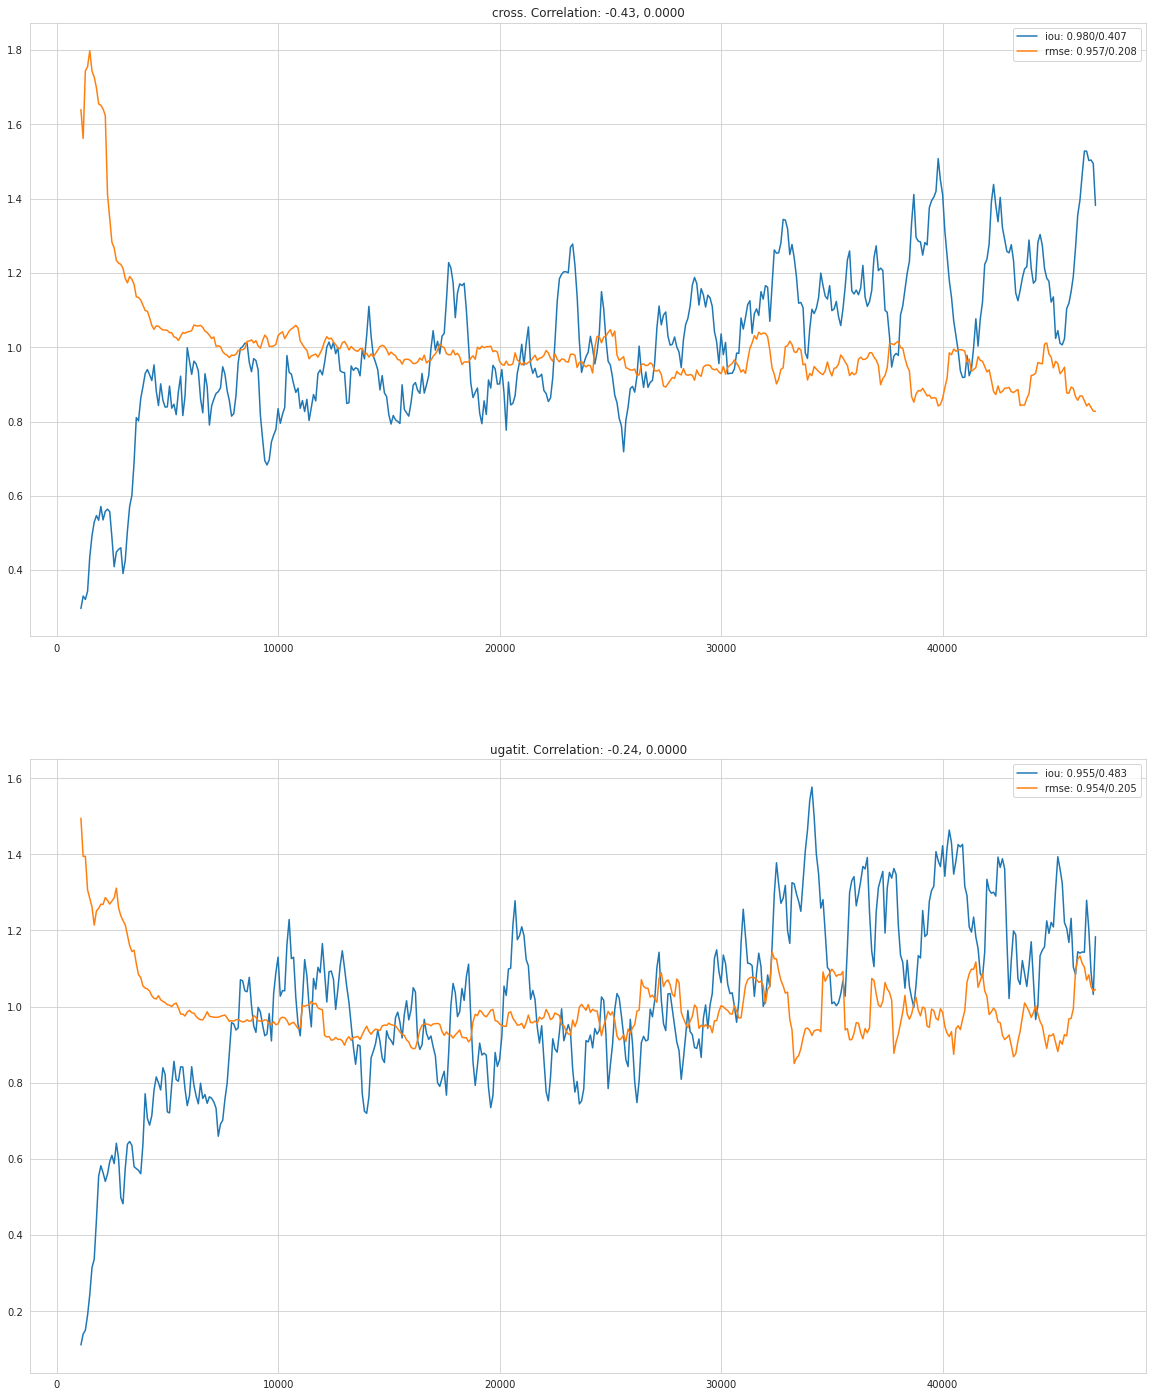

In [0]:
start_index = 1
plt.subplots(figsize=(20,10))
data = ((10,'cross', scale(df_spec_iou_010.iloc[start_index:min_len]), scale(df_spec_score_whole_010.iloc[start_index:min_len])),
        (10, 'ugatit',  scale(df_spec_iou_011.iloc[start_index:min_len]), scale(df_spec_score_whole_011.iloc[start_index:min_len])))

for i,(rm, label, iou, rmse) in enumerate(data):
  plt.subplot(len(data), 1, i+1)
  corr,pv = st.pearsonr(iou.values.squeeze(), rmse.values.squeeze())
  plt.title(f"{label}. Correlation: {corr:.2f}, {pv:.4f}")
  plt.plot(iou.rolling(rm).mean(), label=f"iou: {iou.median()[0]:.3f}/{iou.std()[0]:.3f}")
  plt.plot(rmse.rolling(rm).mean(), label=f"rmse: {rmse.median()[0]:.3f}/{rmse.std()[0]:.3f}")
  plt.legend();

plt.subplots_adjust(top=2);

### Look at losses

#### Adv. domain B

In [0]:
tag_gab = 'G/GAN_A2B'
df_spec_gab_010 = results_010[tag_gab]
df_spec_gab_011 = results_011[tag_gab]


tag_db_real = 'D/D_B_real'
df_spec_db_real_010 = results_010[tag_db_real]
df_spec_db_real_011 = results_011[tag_db_real]



tag_db_fake = 'D/D_B_fake'
df_spec_db_fake_010 = results_010[tag_db_fake]
df_spec_db_fake_011 = results_011[tag_db_fake]

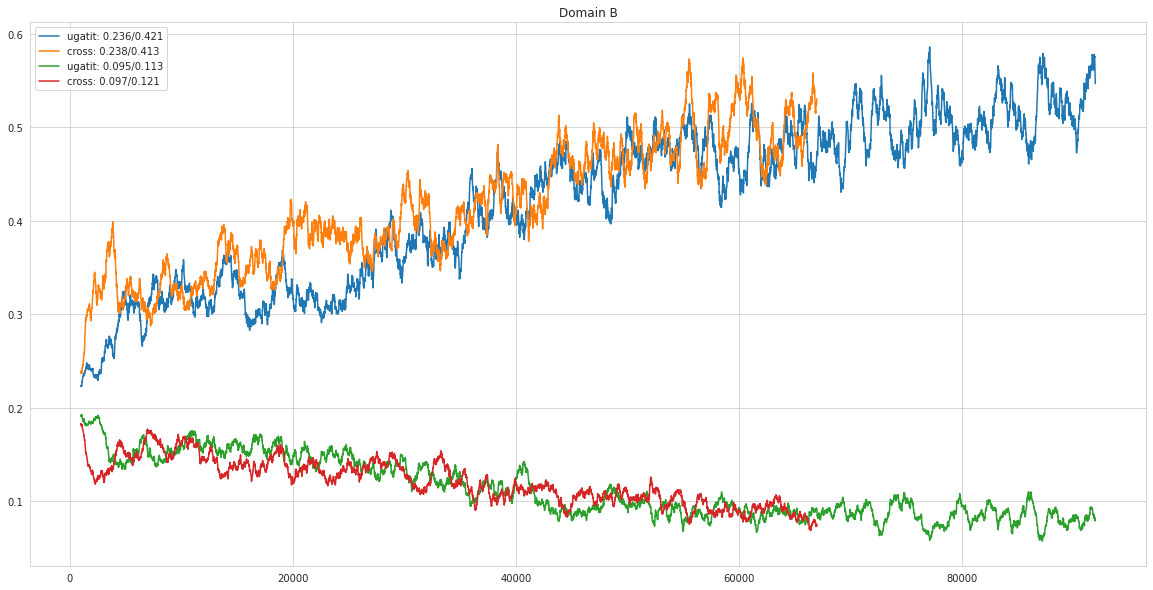

In [15]:
rm = 100
plt.subplots(figsize=(20,10))
plt.title("Domain B")

plt.plot(df_spec_gab_011.rolling(rm).mean(), 
         label=f'ugatit: {df_spec_gab_011.std()[0]:.3f}/{df_spec_gab_011.mean()[0]:.3f}');
plt.plot(df_spec_gab_010.rolling(rm).mean(), 
         label=f'cross: {df_spec_gab_010.std()[0]:.3f}/{df_spec_gab_010.mean()[0]:.3f}');

df_spec_db_fake_comb_010 = (df_spec_db_real_010 + df_spec_db_fake_010) / 2
df_spec_db_fake_comb_011 = (df_spec_db_real_011 + df_spec_db_fake_011) / 2

plt.plot(df_spec_db_fake_comb_011.rolling(rm).mean(), 
         label=f'ugatit: {df_spec_db_fake_comb_011.std()[0]:.3f}/{df_spec_db_fake_comb_011.mean()[0]:.3f}');
plt.plot(df_spec_db_fake_comb_010.rolling(rm).mean(), 
         label=f'cross: {df_spec_db_fake_comb_010.std()[0]:.3f}/{df_spec_db_fake_comb_010.mean()[0]:.3f}');

plt.legend();

- Losses are again hard to distinguish and make the conclusions as it was on the previous stage

#### Adv. domain A

In [0]:
tag_gba = 'G/GAN_B2A'
df_spec_gba_010 = results_010[tag_gba]
df_spec_gba_011 = results_011[tag_gba]


tag_da_real = 'D/D_A_real'
df_spec_da_real_010 = results_010[tag_db_real]
df_spec_da_real_011 = results_011[tag_db_real]



tag_da_fake = 'D/D_A_fake'
df_spec_da_fake_010 = results_010[tag_db_fake]
df_spec_da_fake_011 = results_011[tag_db_fake]


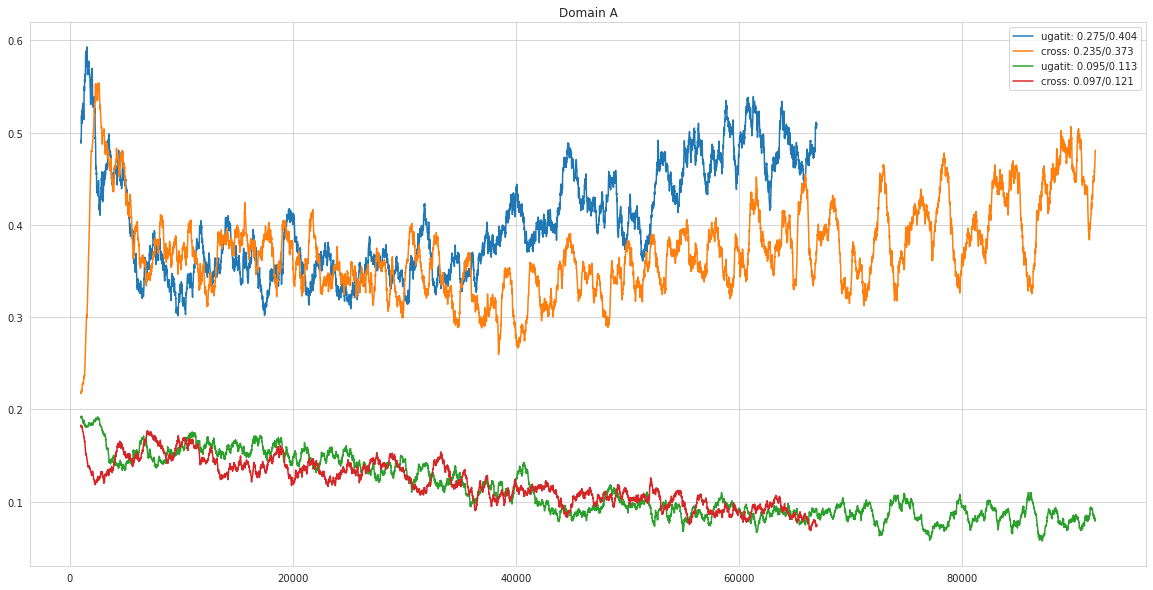

In [17]:
rm = 100
plt.subplots(figsize=(20,10))
plt.title("Domain A")

plt.plot(df_spec_gba_010.rolling(rm).mean(), 
         label=f'ugatit: {df_spec_gba_010.std()[0]:.3f}/{df_spec_gba_010.mean()[0]:.3f}');
plt.plot(df_spec_gba_011.rolling(rm).mean(), 
         label=f'cross: {df_spec_gba_011.std()[0]:.3f}/{df_spec_gba_011.mean()[0]:.3f}');

df_spec_da_fake_comb_010 = (df_spec_da_real_010 + df_spec_da_fake_010) / 2
df_spec_da_fake_comb_011 = (df_spec_da_real_011 + df_spec_da_fake_011) / 2

plt.plot(df_spec_db_fake_comb_011.rolling(rm).mean(), 
         label=f'ugatit: {df_spec_db_fake_comb_011.std()[0]:.3f}/{df_spec_db_fake_comb_011.mean()[0]:.3f}');
plt.plot(df_spec_db_fake_comb_010.rolling(rm).mean(), 
         label=f'cross: {df_spec_db_fake_comb_010.std()[0]:.3f}/{df_spec_db_fake_comb_010.mean()[0]:.3f}');

plt.legend();

#### CAM. domain B

In [0]:
tag_camB = 'G/cam_A2B'
df_spec_camB_010 = results_010[tag_camB]
df_spec_camB_011 = results_011[tag_camB]
df_spec_camB_013 = results_013[tag_camB]

tag_camA = 'G/cam_B2A'
df_spec_camA_010 = results_010[tag_camA]
df_spec_camA_011 = results_011[tag_camA]
df_spec_camA_013 = results_013[tag_camA]

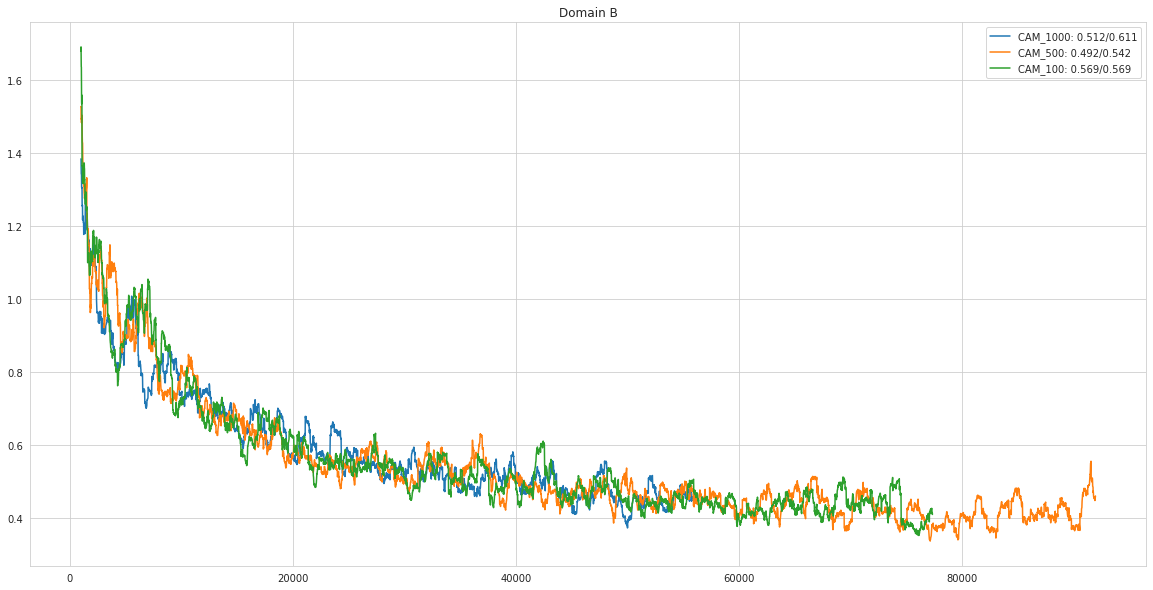

In [0]:
plt.subplots(figsize=(20,10))
rm=100
plt.title("Domain B")
plt.plot(df_spec_camB_010.rolling(rm).mean(), 
         label=f'CAM_1000: {df_spec_camB_010.std()[0]:.3f}/{df_spec_camB_010.mean()[0]:.3f}');
plt.plot(df_spec_camB_011.rolling(rm).mean(), 
         label=f'CAM_500: {df_spec_camB_011.std()[0]:.3f}/{df_spec_camB_011.mean()[0]:.3f}');
plt.plot(df_spec_camB_013.rolling(rm).mean(), 
         label=f'CAM_100: {df_spec_camB_013.std()[0]:.3f}/{df_spec_camB_013.mean()[0]:.3f}');
plt.legend();

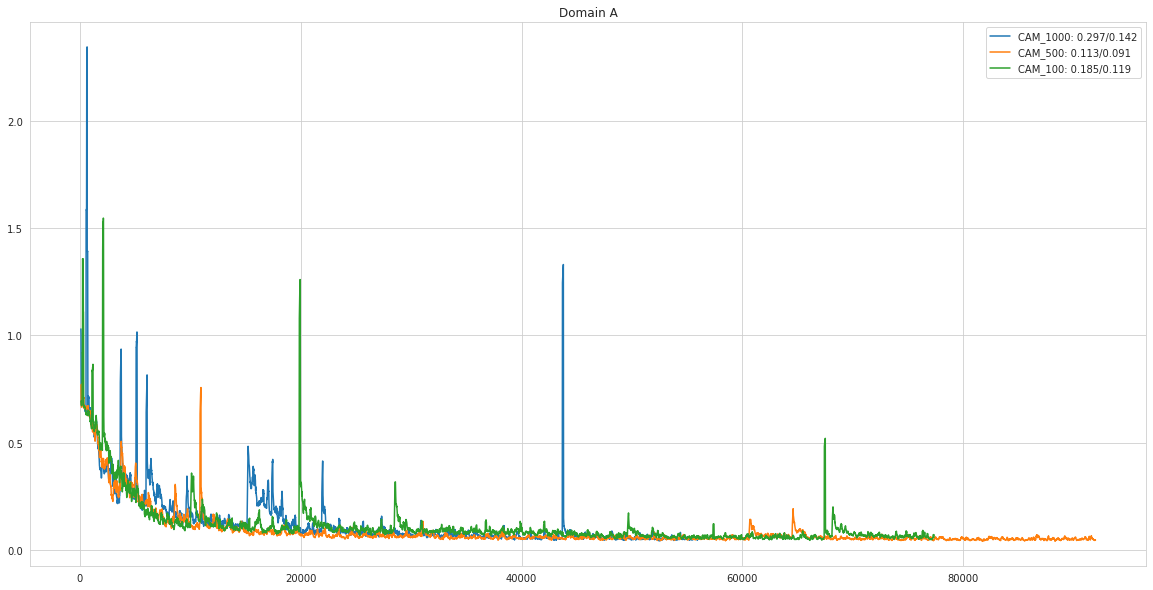

In [0]:
plt.subplots(figsize=(20,10))
rm=10
plt.title("Domain A")
plt.plot(df_spec_camA_010.rolling(rm).mean(), 
         label=f'CAM_1000: {df_spec_camA_010.std()[0]:.3f}/{df_spec_camA_010.mean()[0]:.3f}');
plt.plot(df_spec_camA_011.rolling(rm).mean(), 
         label=f'CAM_500: {df_spec_camA_011.std()[0]:.3f}/{df_spec_camA_011.mean()[0]:.3f}');
plt.plot(df_spec_camA_013.rolling(rm).mean(), 
         label=f'CAM_100: {df_spec_camA_013.std()[0]:.3f}/{df_spec_camA_013.mean()[0]:.3f}');
plt.legend();

In [0]:
tag_idtA = 'G/idt_A'
df_spec_idtA_010 = results_010[tag_idtA]
df_spec_idtA_011 = results_011[tag_idtA]
df_spec_idtA_013 = results_013[tag_idtA]

tag_idtB = 'G/idt_B'
df_spec_idtB_010 = results_010[tag_idtB]
df_spec_idtB_011 = results_011[tag_idtB]
df_spec_idtB_013 = results_013[tag_idtB]

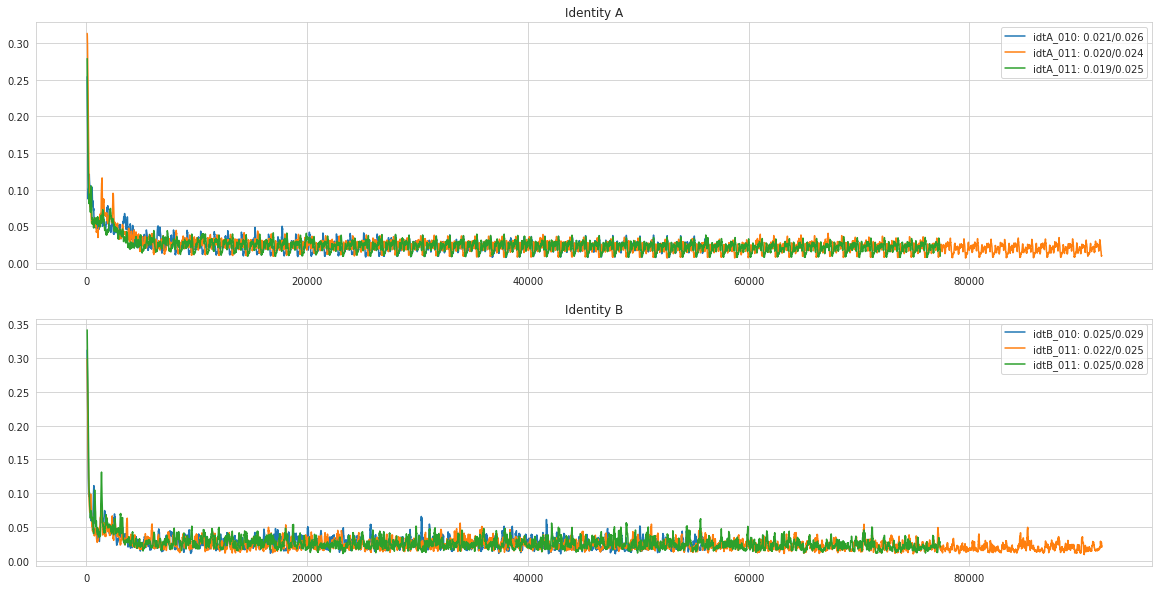

In [0]:
plt.subplots(figsize=(20,10))
rm=10

plt.subplot(2,1,1)
plt.title("Identity A")
plt.plot(df_spec_idtA_010.rolling(rm).mean(), 
         label=f'idtA_010: {df_spec_idtA_010.std()[0]:.3f}/{df_spec_idtA_010.mean()[0]:.3f}');
plt.plot(df_spec_idtA_011.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_011.std()[0]:.3f}/{df_spec_idtA_011.mean()[0]:.3f}');
plt.plot(df_spec_idtA_013.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_013.std()[0]:.3f}/{df_spec_idtA_013.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Identity B")
plt.plot(df_spec_idtB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_idtB_010.std()[0]:.3f}/{df_spec_idtB_010.mean()[0]:.3f}');
plt.plot(df_spec_idtB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_011.std()[0]:.3f}/{df_spec_idtB_011.mean()[0]:.3f}');
plt.plot(df_spec_idtB_013.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_013.std()[0]:.3f}/{df_spec_idtB_013.mean()[0]:.3f}');

plt.legend();

In [0]:
tag_ABA = 'G/cycle_ABA'
df_spec_ABA_010 = results_010[tag_ABA]
df_spec_ABA_011 = results_011[tag_ABA]
df_spec_ABA_013 = results_013[tag_ABA]

tag_BAB = 'G/cycle_BAB'
df_spec_BAB_010 = results_010[tag_BAB]
df_spec_BAB_011 = results_011[tag_BAB]
df_spec_BAB_013 = results_013[tag_BAB]

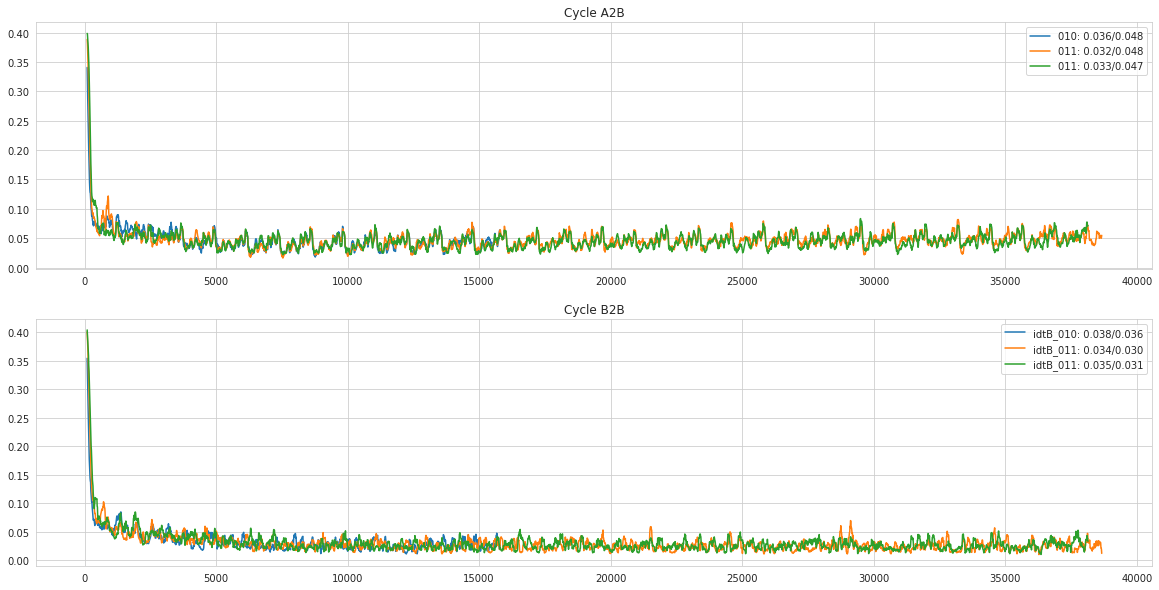

In [0]:
plt.subplots(figsize=(20,10))

plt.subplot(2,1,1)
plt.title("Cycle A2B")
plt.plot(df_spec_ABA_010.rolling(rm).mean(), 
         label=f'010: {df_spec_ABA_010.std()[0]:.3f}/{df_spec_ABA_010.mean()[0]:.3f}');
plt.plot(df_spec_ABA_011.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_011.std()[0]:.3f}/{df_spec_ABA_011.mean()[0]:.3f}');
plt.plot(df_spec_ABA_013.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_013.std()[0]:.3f}/{df_spec_ABA_013.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Cycle B2B")
plt.plot(df_spec_BAB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_BAB_010.std()[0]:.3f}/{df_spec_BAB_010.mean()[0]:.3f}');
plt.plot(df_spec_BAB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_011.std()[0]:.3f}/{df_spec_BAB_011.mean()[0]:.3f}');
plt.plot(df_spec_BAB_013.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_013.std()[0]:.3f}/{df_spec_BAB_013.mean()[0]:.3f}');

plt.legend();

### Ttest

In [0]:
import scipy.stats as st

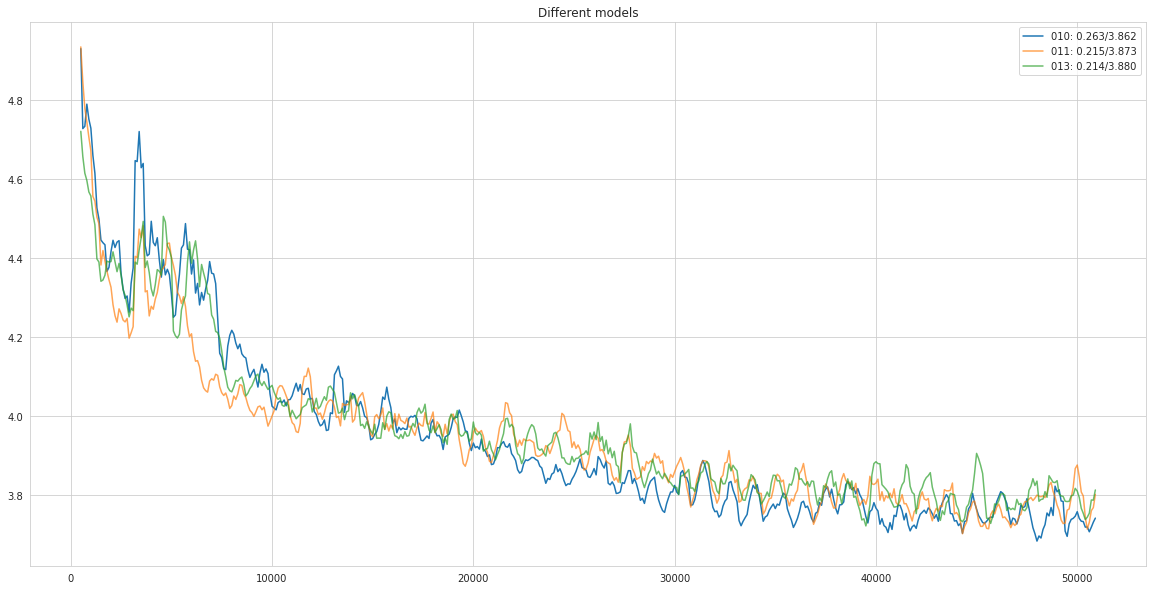

In [0]:
rm=5
plt.subplots(figsize=(20,10))
plt.title("Different models")
plt.plot(df_spec_score_010.rolling(rm).mean(), 
         label=f'010: {df_spec_score_010.std()[0]:.3f}/{df_spec_score_010.median()[0]:.3f}');
plt.plot(df_spec_score_011.rolling(rm).mean().iloc[:min_len], 
         label=f'011: {df_spec_score_011.std()[0]:.3f}/{df_spec_score_011.median()[0]:.3f}',
         alpha=0.7);
plt.plot(df_spec_score_013.rolling(rm).mean().iloc[:min_len], 
         label=f'013: {df_spec_score_013.std()[0]:.3f}/{df_spec_score_013.median()[0]:.3f}',
         alpha=0.7);
plt.legend();

In [0]:
t_1_2 = st.ttest_ind(df_spec_score_010.values, df_spec_score_011.values)
t_1_3 = st.ttest_ind(df_spec_score_010.values, df_spec_score_013.values)
t_2_3 = st.ttest_ind(df_spec_score_011.values, df_spec_score_013.values)

In [0]:
print(f'H0 vs H1: {t_1_2}\n',
      f'H0 vs H2: {t_1_3}\n',
      f"H1 vs H2: {t_2_3}")

H0 vs H1: Ttest_indResult(statistic=array([1.71926998]), pvalue=array([0.08584809]))
 H0 vs H2: Ttest_indResult(statistic=array([0.71586739]), pvalue=array([0.47422741]))
 H1 vs H2: Ttest_indResult(statistic=array([-1.14987522]), pvalue=array([0.25043187]))


In [0]:
# take values where scores are more stable
idx = 10000
t_1_2 = st.ttest_ind(df_spec_score_010[df_spec_score_010.index > idx].values, 
                     df_spec_score_011[df_spec_score_011.index > idx].values)
t_1_3 = st.ttest_ind(df_spec_score_010[df_spec_score_010.index > idx].values, 
                     df_spec_score_013[df_spec_score_013.index > idx].values)
t_2_3 = st.ttest_ind(df_spec_score_011[df_spec_score_011.index > idx].values, 
                     df_spec_score_013[df_spec_score_013.index > idx].values)

In [0]:
print("H0 mean: {:.4f}, H0 std: {:.4f}".format(df_spec_score_010[df_spec_score_010.index > idx].mean().iloc[0], 
                                       df_spec_score_010[df_spec_score_010.index > idx].std().iloc[0]))
print()
print("H1 mean: {:.4f}, H1 std: {:.4f}".format(df_spec_score_011[df_spec_score_011.index > idx].mean().iloc[0], 
                                       df_spec_score_011[df_spec_score_011.index > idx].std().iloc[0]))
print()
print("H2 mean: {:.4f}, H2 std: {:.4f}".format(df_spec_score_013[df_spec_score_013.index > idx].mean().iloc[0], 
                                       df_spec_score_013[df_spec_score_013.index > idx].std().iloc[0]))

H0 mean: 3.8456, H0 std: 0.1197

H1 mean: 3.8535, H1 std: 0.1166

H2 mean: 3.8604, H2 std: 0.1120


In [0]:
print(f'H0 vs H1: {t_1_2}\n',
      f'H0 vs H2: {t_1_3}\n',
      f"H1 vs H2: {t_2_3}")

H0 vs H1: Ttest_indResult(statistic=array([-0.98959662]), pvalue=array([0.32263908]))
 H0 vs H2: Ttest_indResult(statistic=array([-1.88904765]), pvalue=array([0.05921254]))
 H1 vs H2: Ttest_indResult(statistic=array([-0.93429577]), pvalue=array([0.35038579]))
